# Start of the Project
Importing Libraries and Data
Creating Essential DataFrames
Defining Feature Engineering Functions

In [14]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

# Assuming the CSV files are in the same directory as your Python script or Jupyter Notebook

# Import Game data
# Irrelevant for this model
#games_data = pd.read_csv('nfl-big-data-bowl-2024/games.csv')

# Import Play data
plays_data = pd.read_csv('nfl-big-data-bowl-2024/plays.csv')

# Import Player data
players_data = pd.read_csv('nfl-big-data-bowl-2024/players.csv')

# Import Tackles data
tackles_data = pd.read_csv('nfl-big-data-bowl-2024/tackles.csv')

#sample of 1 tracking week
#tracking_data_1 = pd.read_csv(f'nfl-big-data-bowl-2024/tracking_week_1.csv')

# Example for importing all weeks of Tracking data
# Adjust the range based on the actual weeks in your dataset
tracking_data_all_weeks = pd.concat([pd.read_csv(f'nfl-big-data-bowl-2024/tracking_week_{week}.csv') for week in range(1, 10)])

# Now you can use these DataFrames in your analysis

In [15]:
def calculate_max_speed(tracking_data, nflId):
    # Filter tracking data for the specific player
    player_tracking = tracking_data[tracking_data['nflId'] == nflId]
    max_speed = player_tracking['s'].max()
    return max_speed

def calculate_max_acceleration(tracking_data, nflId):
    # Filter tracking data for the specific player
    player_tracking = tracking_data[tracking_data['nflId'] == nflId]
    max_speed = player_tracking['a'].max()
    return max_speed


In [16]:
def calculate_average_speed(tracking_data, nflId):
    # Filter tracking data for the specific player
    player_tracking = tracking_data[tracking_data['nflId'] == nflId]
    average_speed = player_tracking['s'].sum() / len(player_tracking['s'])
    return average_speed

# Example usage:
# Assuming you have loaded the tracking data into a DataFrame named 'tracking_data'
# and the player data into a DataFrame named 'player_data'

# Replace 'your_nflId_here' with the actual nflId of the player you want to calculate the average speed for
nflId_to_calculate = 29550	  

average_speed = calculate_average_speed(tracking_data_all_weeks, nflId_to_calculate)
average_speed_min = average_speed * 60
print(f"Average speed for player with nflId {nflId_to_calculate}: {average_speed} yards/second")
print(f"Average speed for player with nflId {nflId_to_calculate}: {average_speed_min} yards/minute")

def calculate_normalized_aggression_score(tackles_data, nflId):
    # Filter tackles data for the specific player
    player_tackles = tackles_data[tackles_data['nflId'] == nflId]

    if len(player_tackles) == 0:
        #print(f"Player with nflId {nflId} not found in the tackles data.") 
        return 0

    # Calculate normalized aggression score based on tackles, assisted tackles, forced fumbles, and missed tackles
    
    pts = 0

    pts = pts + len(player_tackles)

    pts = pts + (2 * player_tackles['tackle'].sum()) #additional weight for being credited for the tackle
    pts = pts + player_tackles['assist'].sum()
    
    pts = pts + (2 * player_tackles[player_tackles['pff_missedTackle'] == 0]['pff_missedTackle'].count()) #additional point for the successful tackle
    pts = pts + (player_tackles[player_tackles['pff_missedTackle'] == 1]['pff_missedTackle'].count()) 
    pts = pts + (3 * player_tackles['forcedFumble'].sum()) #bonus points for forcing a fumble

    #choosing not to average out based on the number of tackles they've been involved in since a higher or lower number of tackles should indicate a little bit about their role
    
    aggression_score = pts

    return aggression_score


# Example usage:
# Assuming you have loaded the tackles data into a DataFrame named 'tackles_data'

# Replace 'your_nflId_here' with the actual nflId of the player you want to calculate the normalized aggression score for
nflId_to_calculate_aggression_score = 55104

player_aggression_score = calculate_normalized_aggression_score(
    tackles_data, nflId_to_calculate_aggression_score)
if player_aggression_score is not None:
    print(
        f"Normalized Aggression Score for player with nflId {nflId_to_calculate_aggression_score}: {player_aggression_score:.2f}"
    )

def calculate_bmi(player_data, nflId):
    # Filter player data for the specific player
    player_info = player_data[player_data['nflId'] == nflId]

    if len(player_info) == 0:
        print(f"Player with nflId {nflId} not found.")
        return None

    # Extract weight and height
    weight_kg = player_info['weight'].values[0] * 0.453592  # Convert pounds to kilograms
    height_meters = convert_height_to_meters(player_info['height'].values[0])  # Convert feet and inches to meters

    # Calculate BMI
    bmi = weight_kg / (height_meters ** 2)

    return bmi

def convert_height_to_meters(height):
    # Convert height from feet and inches to meters
    feet, inches = map(int, height.split('-'))
    height_meters = (feet * 12 + inches) * 0.0254  # 1 foot = 12 inches, 1 inch = 0.0254 meters
    return height_meters

# Example usage:
# Assuming you have loaded the player data into a DataFrame named 'player_data'

# Replace 'your_nflId_here' with the actual nflId of the player you want to calculate the BMI for
nflId_to_calculate_bmi = 29550  

player_bmi = calculate_bmi(players_data, nflId_to_calculate_bmi)
if player_bmi is not None:
    print(f"BMI for player with nflId {nflId_to_calculate_bmi}: {player_bmi:.2f}")

Average speed for player with nflId 29550: 2.399963427377221 yards/second
Average speed for player with nflId 29550: 143.99780564263324 yards/minute
Normalized Aggression Score for player with nflId 55104: 8.00
BMI for player with nflId 29550: 39.92


In [17]:
nflId = 29550
fouls = [plays_data[plays_data['foulNFLId1'] == nflId]['foulName1'], plays_data[plays_data['foulNFLId2'] == nflId]['foulName2']]

In [18]:
def calculate_penalty_record(plays_data, nflId):
    offensive_penalties, defensive_penalties, accidental_penalties, contact_fouls, flagrant_fouls = [0] * 5

    
    fouls = [plays_data[plays_data['foulNFLId1'] == nflId]['foulName1'], plays_data[plays_data['foulNFLId2'] == nflId]['foulName2']]

    for foul_set in fouls:
        offensive_penalties = offensive_penalties + foul_set[foul_set=='Offensive Holding'].count()
        offensive_penalties = offensive_penalties + foul_set[foul_set=='Ineligible Downfield Pass'].count()
        offensive_penalties = offensive_penalties + foul_set[foul_set=='Offensive Pass Interference'].count()
        offensive_penalties = offensive_penalties + foul_set[foul_set=='Chop Block'].count()
        offensive_penalties = offensive_penalties + foul_set[foul_set=='Illegal Motion'].count()
        offensive_penalties = offensive_penalties + foul_set[foul_set=='Illegal Blindside Block'].count()
        offensive_penalties = offensive_penalties + foul_set[foul_set=='Illegal Forward Pass'].count()


        defensive_penalties = defensive_penalties + foul_set[foul_set=='Defensive Holding'].count()
        defensive_penalties = defensive_penalties + foul_set[foul_set=='Defensive Offside'].count()
        defensive_penalties = defensive_penalties + foul_set[foul_set=='Roughing the Passer'].count()
        defensive_penalties = defensive_penalties + foul_set[foul_set=='Illegal Contact'].count()
        defensive_penalties = defensive_penalties + foul_set[foul_set=='Horse Collar Tackle'].count()
        defensive_penalties = defensive_penalties + foul_set[foul_set=='Defensive Pass Interference'].count()
        defensive_penalties = defensive_penalties + foul_set[foul_set=='Defensive Too Many Men on Field'].count()


        contact_fouls = contact_fouls + foul_set[foul_set=='Illegal Use of Hands'].count()
        contact_fouls = contact_fouls + foul_set[foul_set=='Illegal Block Above the Waist'].count()
        contact_fouls = contact_fouls + foul_set[foul_set=='Low Block'].count()

        flagrant_fouls = flagrant_fouls + foul_set[foul_set=='Unnecessary Roughness'].count()
        flagrant_fouls = flagrant_fouls + foul_set[foul_set=='Face Mask'].count()
        flagrant_fouls = flagrant_fouls + foul_set[foul_set=='Unsportsmanlike Conduct'].count()
        flagrant_fouls = flagrant_fouls + foul_set[foul_set=='Taunting'].count()
        flagrant_fouls = flagrant_fouls + foul_set[foul_set=='Disqualification'].count()
        flagrant_fouls = flagrant_fouls + foul_set[foul_set=='Tripping'].count()


        accidental_penalties = accidental_penalties + foul_set[foul_set=='Illegal Formation'].count()
        accidental_penalties = accidental_penalties + foul_set[foul_set=='Illegal Shift'].count()

    record = {'Offensive Penalties': [offensive_penalties], 'Defensive Penalties': [defensive_penalties], 'Flagrant Fouls': [flagrant_fouls], 'Accidental Penalties': [accidental_penalties], 'Contact Fouls': [contact_fouls]}

    return record

nflId_to_calculate_record = 43368  

player_penaly_record = calculate_penalty_record(plays_data, nflId_to_calculate_record)
if player_penaly_record is not None:
    print(f"Penalty Record for player with nflId {nflId_to_calculate_record}: {player_penaly_record}")

Penalty Record for player with nflId 43368: {'Offensive Penalties': [2], 'Defensive Penalties': [0], 'Flagrant Fouls': [0], 'Accidental Penalties': [0], 'Contact Fouls': [0]}


In [19]:
def count_ball_carries(play_data, ball_carrier_id):
    # Filter play data for completed passes where the specified player is the ball carrier
    carries = play_data[(play_data['ballCarrierId'] == ball_carrier_id)]

    # Count the number of plays where the player carries the ball. 
    # play data is event based, not time stamped. therefore multiple plays may occur during the same down
    # if a player is counted more than once during a down, it may indicate that the player held on to the ball for a long time, thus adding extra to the counter, but this doesn't indicate the actual length of time
    return len(carries)

# Example usage:
# Assuming you have loaded the play data into a DataFrame named 'plays_data'

# Replace 'your_ballCarrierId_here' with the actual ballCarrierId of the player you want to analyze
ballCarrierId_to_analyze = 33130	  

ball_carries = count_ball_carries(plays_data, ballCarrierId_to_analyze)
print(f"Number of passes caught by player with ballCarrierId {ballCarrierId_to_analyze}: {ball_carries}")


Number of passes caught by player with ballCarrierId 33130: 2


In [20]:
def count_passes_caught(play_data, ball_carrier_id):
    # Filter play data for completed passes where the specified player is the ball carrier
    player_passes_caught = play_data[(play_data['ballCarrierId'] == ball_carrier_id) & (play_data['passResult'] == 'C')]

    # Count the number of passes caught
    num_passes_caught = len(player_passes_caught)

    return num_passes_caught

# Example usage:
# Assuming you have loaded the play data into a DataFrame named 'plays_data'

# Replace 'your_ballCarrierId_here' with the actual ballCarrierId of the player you want to analyze
ballCarrierId_to_analyze = 33130	  

passes_caught = count_passes_caught(plays_data, ballCarrierId_to_analyze)
print(f"Number of passes caught by player with ballCarrierId {ballCarrierId_to_analyze}: {passes_caught}")


Number of passes caught by player with ballCarrierId 33130: 2


In [21]:
def count_scrambles(play_data, ball_carrier_id):
    # Filter play data for completed passes where the specified player is the ball carrier
    player_passes_caught = play_data[(play_data['ballCarrierId'] == ball_carrier_id) & (play_data['passResult'] == 'R')]

    # Count the number of scrambles
    num_scrambles = len(player_passes_caught)

    return num_scrambles

# Example usage:
# Assuming you have loaded the play data into a DataFrame named 'plays_data'

# Replace 'your_ballCarrierId_here' with the actual ballCarrierId of the player you want to analyze
ballCarrierId_to_analyze = 47784	  

scrambles = count_scrambles(plays_data, ballCarrierId_to_analyze)
print(f"Number of passes caught by player with ballCarrierId {ballCarrierId_to_analyze}: {scrambles}")


Number of passes caught by player with ballCarrierId 47784: 24


# Category Rules
i. No category should contain  less than 50 samples
ii. Categories can merge if it is on the same team and if roles are similar
iii. Offensive and Defensive categories should be balanced in number and equivalence
iv. The resulting category name will generalize all members of the category

In [22]:
# grouping similar positions

modified_players_data = players_data.copy()

#Offensive Roles
#merging RB and FB
modified_players_data["position"]=np.where(modified_players_data["position"] == 'FB', 'RB', modified_players_data["position"])
#merging TE and LS
modified_players_data["position"]=np.where(modified_players_data["position"] == 'LS', 'TE', modified_players_data["position"])
#merging C and G
modified_players_data["position"]=np.where(modified_players_data["position"] == 'C', 'C-G', modified_players_data["position"])
modified_players_data["position"]=np.where(modified_players_data["position"] == 'G', 'C-G', modified_players_data["position"])

#Defensive Roles
#merging DB and CB 
modified_players_data["position"]=np.where(modified_players_data["position"] == 'DB', 'CB', modified_players_data["position"])
#merging DE and OLB
modified_players_data["position"]=np.where(modified_players_data["position"] == 'DE', 'DE-OLB', modified_players_data["position"])
modified_players_data["position"]=np.where(modified_players_data["position"] == 'OLB', 'DE-OLB', modified_players_data["position"])
#merging NT and DT 
modified_players_data["position"]=np.where(modified_players_data["position"] == 'NT', 'DT', modified_players_data["position"])
#merging SS and FS 
modified_players_data["position"]=np.where(modified_players_data["position"] == 'SS', 'S', modified_players_data["position"])
modified_players_data["position"]=np.where(modified_players_data["position"] == 'FS', 'S', modified_players_data["position"])
#merging ILB and MLB 
modified_players_data["position"]=np.where(modified_players_data["position"] == 'ILB', 'LB', modified_players_data["position"])
modified_players_data["position"]=np.where(modified_players_data["position"] == 'MLB', 'LB', modified_players_data["position"])


In [23]:
modified_players_data['position'].value_counts()

position
DE-OLB    265
WR        218
CB        192
DT        158
C-G       158
S         142
RB        138
TE        126
T         121
LB        104
QB         61
Name: count, dtype: int64

# Running the Model
Defining the Feature Table
Splitting into train, test, and validation datasets
Running the Decision Tree Classifier

array([[<Axes: title={'center': 'gameId'}>,
        <Axes: title={'center': 'playId'}>,
        <Axes: title={'center': 'nflId'}>],
       [<Axes: title={'center': 'frameId'}>,
        <Axes: title={'center': 'jerseyNumber'}>,
        <Axes: title={'center': 'x'}>],
       [<Axes: title={'center': 'y'}>, <Axes: title={'center': 's'}>,
        <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'dis'}>, <Axes: title={'center': 'o'}>,
        <Axes: title={'center': 'dir'}>]], dtype=object)

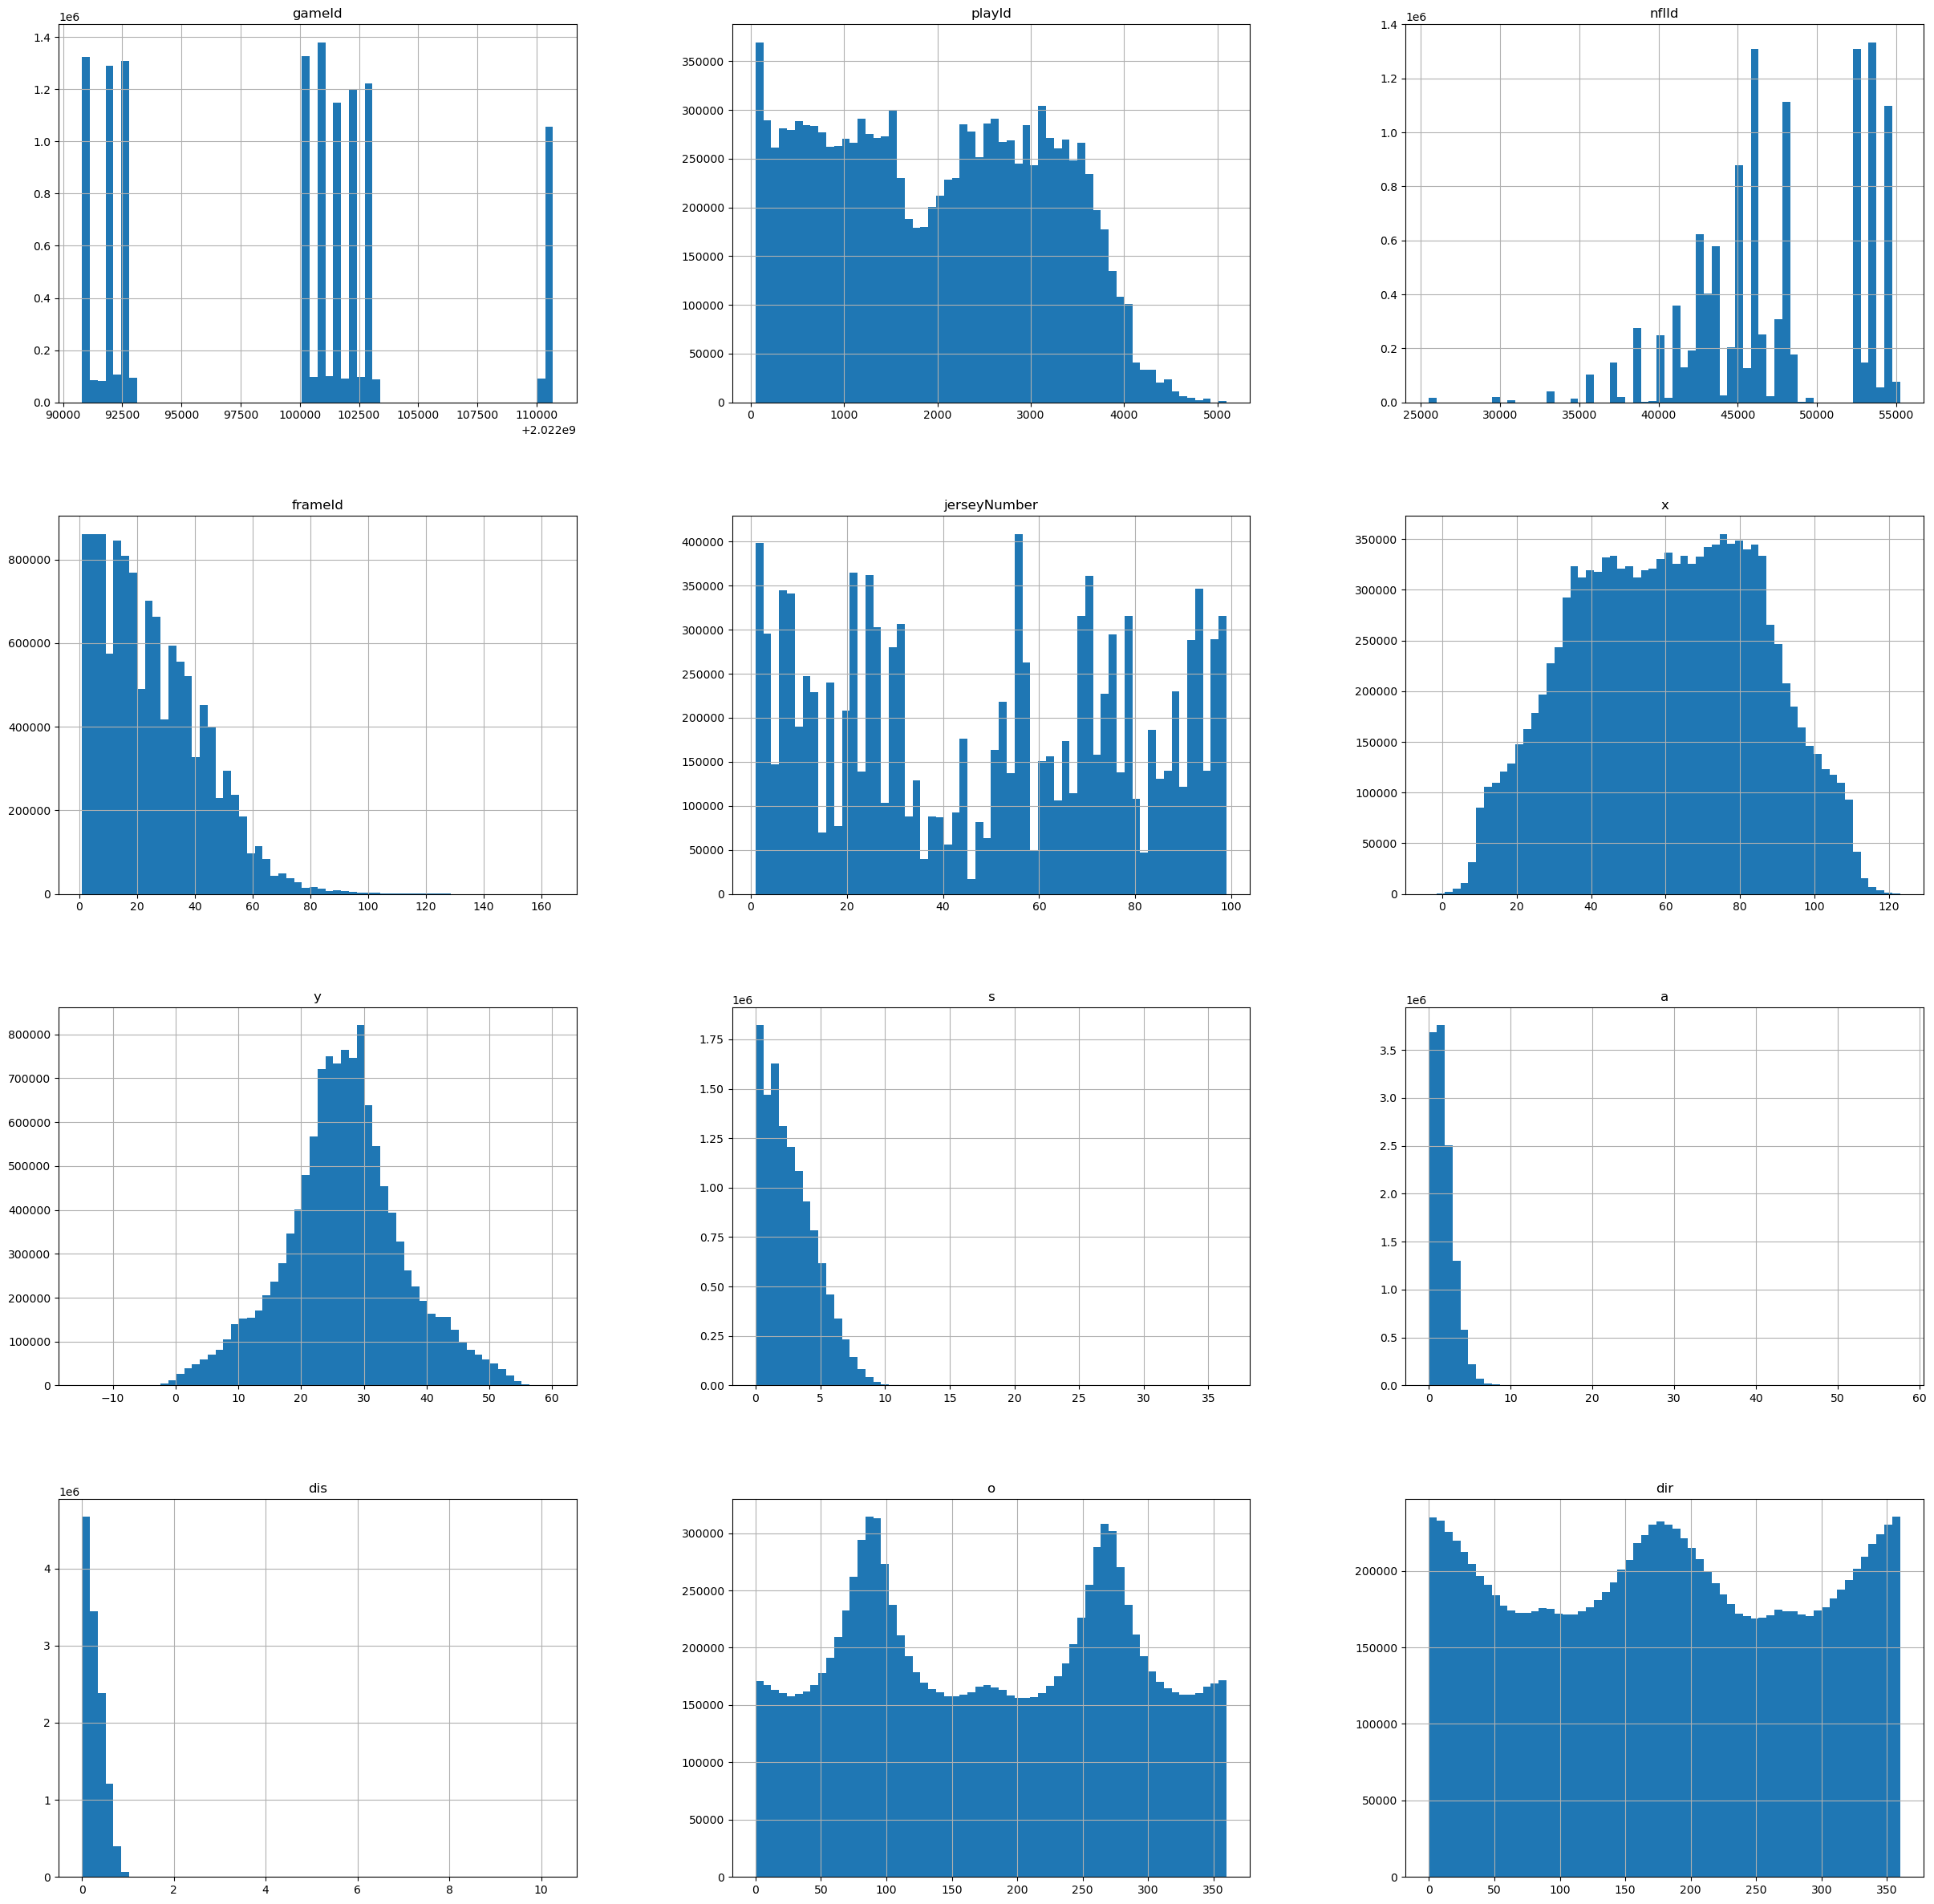

In [24]:
tracking_data_all_weeks.hist(bins=60, figsize=[30,30])

In [25]:
modified_players_data.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


In [26]:
jersey_num_rows = tracking_data_all_weeks[tracking_data_all_weeks["nflId"] == 25511]
jersey_num_rows['jerseyNumber'].values[0]

12.0

In [27]:
feature_table = pd.DataFrame()
nflIds = modified_players_data["nflId"]
for id in nflIds:
    player_bmi = calculate_bmi(modified_players_data, id)
    player_aggression_score = calculate_normalized_aggression_score(tackles_data, id)
    #average_speed = calculate_average_speed(tracking_data_all_weeks, id)
    max_speed = calculate_max_speed(tracking_data_all_weeks, id)
    max_acceleration = calculate_max_acceleration(tracking_data_all_weeks, id)
    passes_caught = count_passes_caught(plays_data, id)
    player_position_index = modified_players_data.index[modified_players_data["nflId"] == id]
    player_position = modified_players_data.at[player_position_index.values[0], 'position']
    player_scrambles = count_scrambles(plays_data, id)
    jersey_num_rows = tracking_data_all_weeks[tracking_data_all_weeks["nflId"] == id]
    jersey_num = jersey_num_rows['jerseyNumber'].values[0]
    ball_carries = count_ball_carries(plays_data, id)
    
    new_data = pd.DataFrame(data={'nflId': [id],
                                  'Jersey Number': [jersey_num],
                                  'BMI': [player_bmi],
                                  'Top Speed': [max_speed], #'Average Speed': [player_aggression_score],
                                  'Maximum Acceleration': [max_acceleration],
                                  'Aggression Score': [player_aggression_score],
                                  'Passes Caught': [passes_caught],
                                  'Ball Carries': [ball_carries],
                                  'Scrambles': [player_scrambles],
                                  **calculate_penalty_record(plays_data, id),
                                  'Position': [player_position]})
    # Concatenate the existing data with the new table
    feature_table = pd.concat([feature_table, new_data], ignore_index=True)

# Display the updated table
feature_table 


,nflId,Jersey Number,BMI,Top Speed,Maximum Acceleration,Aggression Score,Passes Caught,Ball Carries,Scrambles,Offensive Penalties,Defensive Penalties,Flagrant Fouls,Accidental Penalties,Contact Fouls,Position
0,25511,12.0,27.387557,7.67,9.95,0,0,4,3,0,0,0,0,0,QB
1,29550,71.0,39.924971,6.56,3.73,0,0,0,0,0,0,0,0,0,T
2,29851,12.0,28.887970,8.84,8.95,0,0,7,6,0,0,0,0,0,QB
3,30842,89.0,30.854606,7.23,10.72,0,1,1,0,0,0,0,0,0,TE
4,33084,2.0,26.413777,7.89,12.45,0,0,8,6,0,0,0,0,0,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1678,55200,90.0,30.739046,6.92,6.06,5,0,0,0,0,0,0,0,0,DT
1679,55212,35.0,31.193262,6.32,4.00,0,0,0,0,0,0,0,0,0,LB
1680,55239,94.0,38.517294,6.90,4.73,12,0,0,0,0,0,0,0,0,DT
1681,55240,46.0,24.407537,7.37,6.40,14,0,0,0,0,0,0,0,0,CB


In [43]:

# Define features (X) and target variable (y)
features = feature_table[['BMI', 'Jersey Number', 'Top Speed', 'Maximum Acceleration', 'Aggression Score', 'Passes Caught', 'Ball Carries', 'Scrambles','Offensive Penalties', 'Defensive Penalties', 'Flagrant Fouls', 'Accidental Penalties', 'Contact Fouls']] 
target = feature_table['Position'] 

# Split the dataset into training, testing, and validation sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.15, random_state=42)
#X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.20, random_state=42)



In [44]:
model_parameters = {'max_depth':[5, 4, 3], 'criterion':['gini', 'entropy', 'log_loss'], 'random_state':[42, None, 5], 'ccp_alpha':[0, 0.01, 0.02, 0.03]}
tree = DecisionTreeClassifier()
clf = GridSearchCV(tree, model_parameters, cv=10)
clf.fit(X_train, y_train)
clf.best_estimator_

DecisionTreeClassifier(ccp_alpha=0, max_depth=5)

In [47]:
# Initialize the decision tree classifier
classifier = DecisionTreeClassifier(max_depth=5, ccp_alpha=0.00)

# Train the model
classifier.fit(X_train, y_train)

# Make predictions on the test set
y_pred = classifier.predict(X_test)
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

Classification Report:
              precision    recall  f1-score   support

         C-G       0.73      0.40      0.52        20
          CB       0.56      0.81      0.67        27
      DE-OLB       0.70      0.80      0.74        40
          DT       0.95      0.87      0.91        23
          LB       0.50      0.25      0.33        16
          QB       1.00      0.73      0.84        11
          RB       0.61      0.81      0.69        21
           S       0.50      0.13      0.21        23
           T       0.52      0.76      0.62        17
          TE       0.95      0.86      0.90        22
          WR       0.73      0.91      0.81        33

    accuracy                           0.70       253
   macro avg       0.70      0.67      0.66       253
weighted avg       0.70      0.70      0.67       253



# Plotting the Results

In [29]:
# Display classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# # Display Precision Score
# print("Accuracy:")
# print(accuracy_score(y_test, y_pred))


# # Display Precision Score
# print("Precision Score:")
# print(precision_score(y_test, y_pred, average='macro'))

# # Display Recall Score
# print("Recall Score:")
# print(recall_score(y_test, y_pred,average='macro'))

# Display Feature Importances
feature_importance = pd.DataFrame(classifier.feature_importances_ , index=features.columns)
feature_importance

Classification Report:
              precision    recall  f1-score   support

         C-G       0.73      0.40      0.52        20
          CB       0.59      0.85      0.70        27
      DE-OLB       0.52      0.85      0.64        40
          DT       0.78      0.61      0.68        23
          LB       0.00      0.00      0.00        16
          QB       0.83      0.45      0.59        11
          RB       0.85      0.81      0.83        21
           S       0.60      0.26      0.36        23
           T       0.52      0.76      0.62        17
          TE       1.00      0.64      0.78        22
          WR       0.68      0.91      0.78        33

    accuracy                           0.65       253
   macro avg       0.65      0.60      0.59       253
weighted avg       0.64      0.65      0.62       253



/Users/smithsonarrey/miniconda3/envs/nfl_player_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/smithsonarrey/miniconda3/envs/nfl_player_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/smithsonarrey/miniconda3/envs/nfl_player_classifier/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter t

,0
BMI,0.464384
Jersey Number,0.152667
Top Speed,0.012847
Maximum Acceleration,0.006336
Aggression Score,0.323535
Passes Caught,0.034340
Ball Carries,0.005891
Scrambles,0.000000
Offensive Penalties,0.000000
Defensive Penalties,0.000000


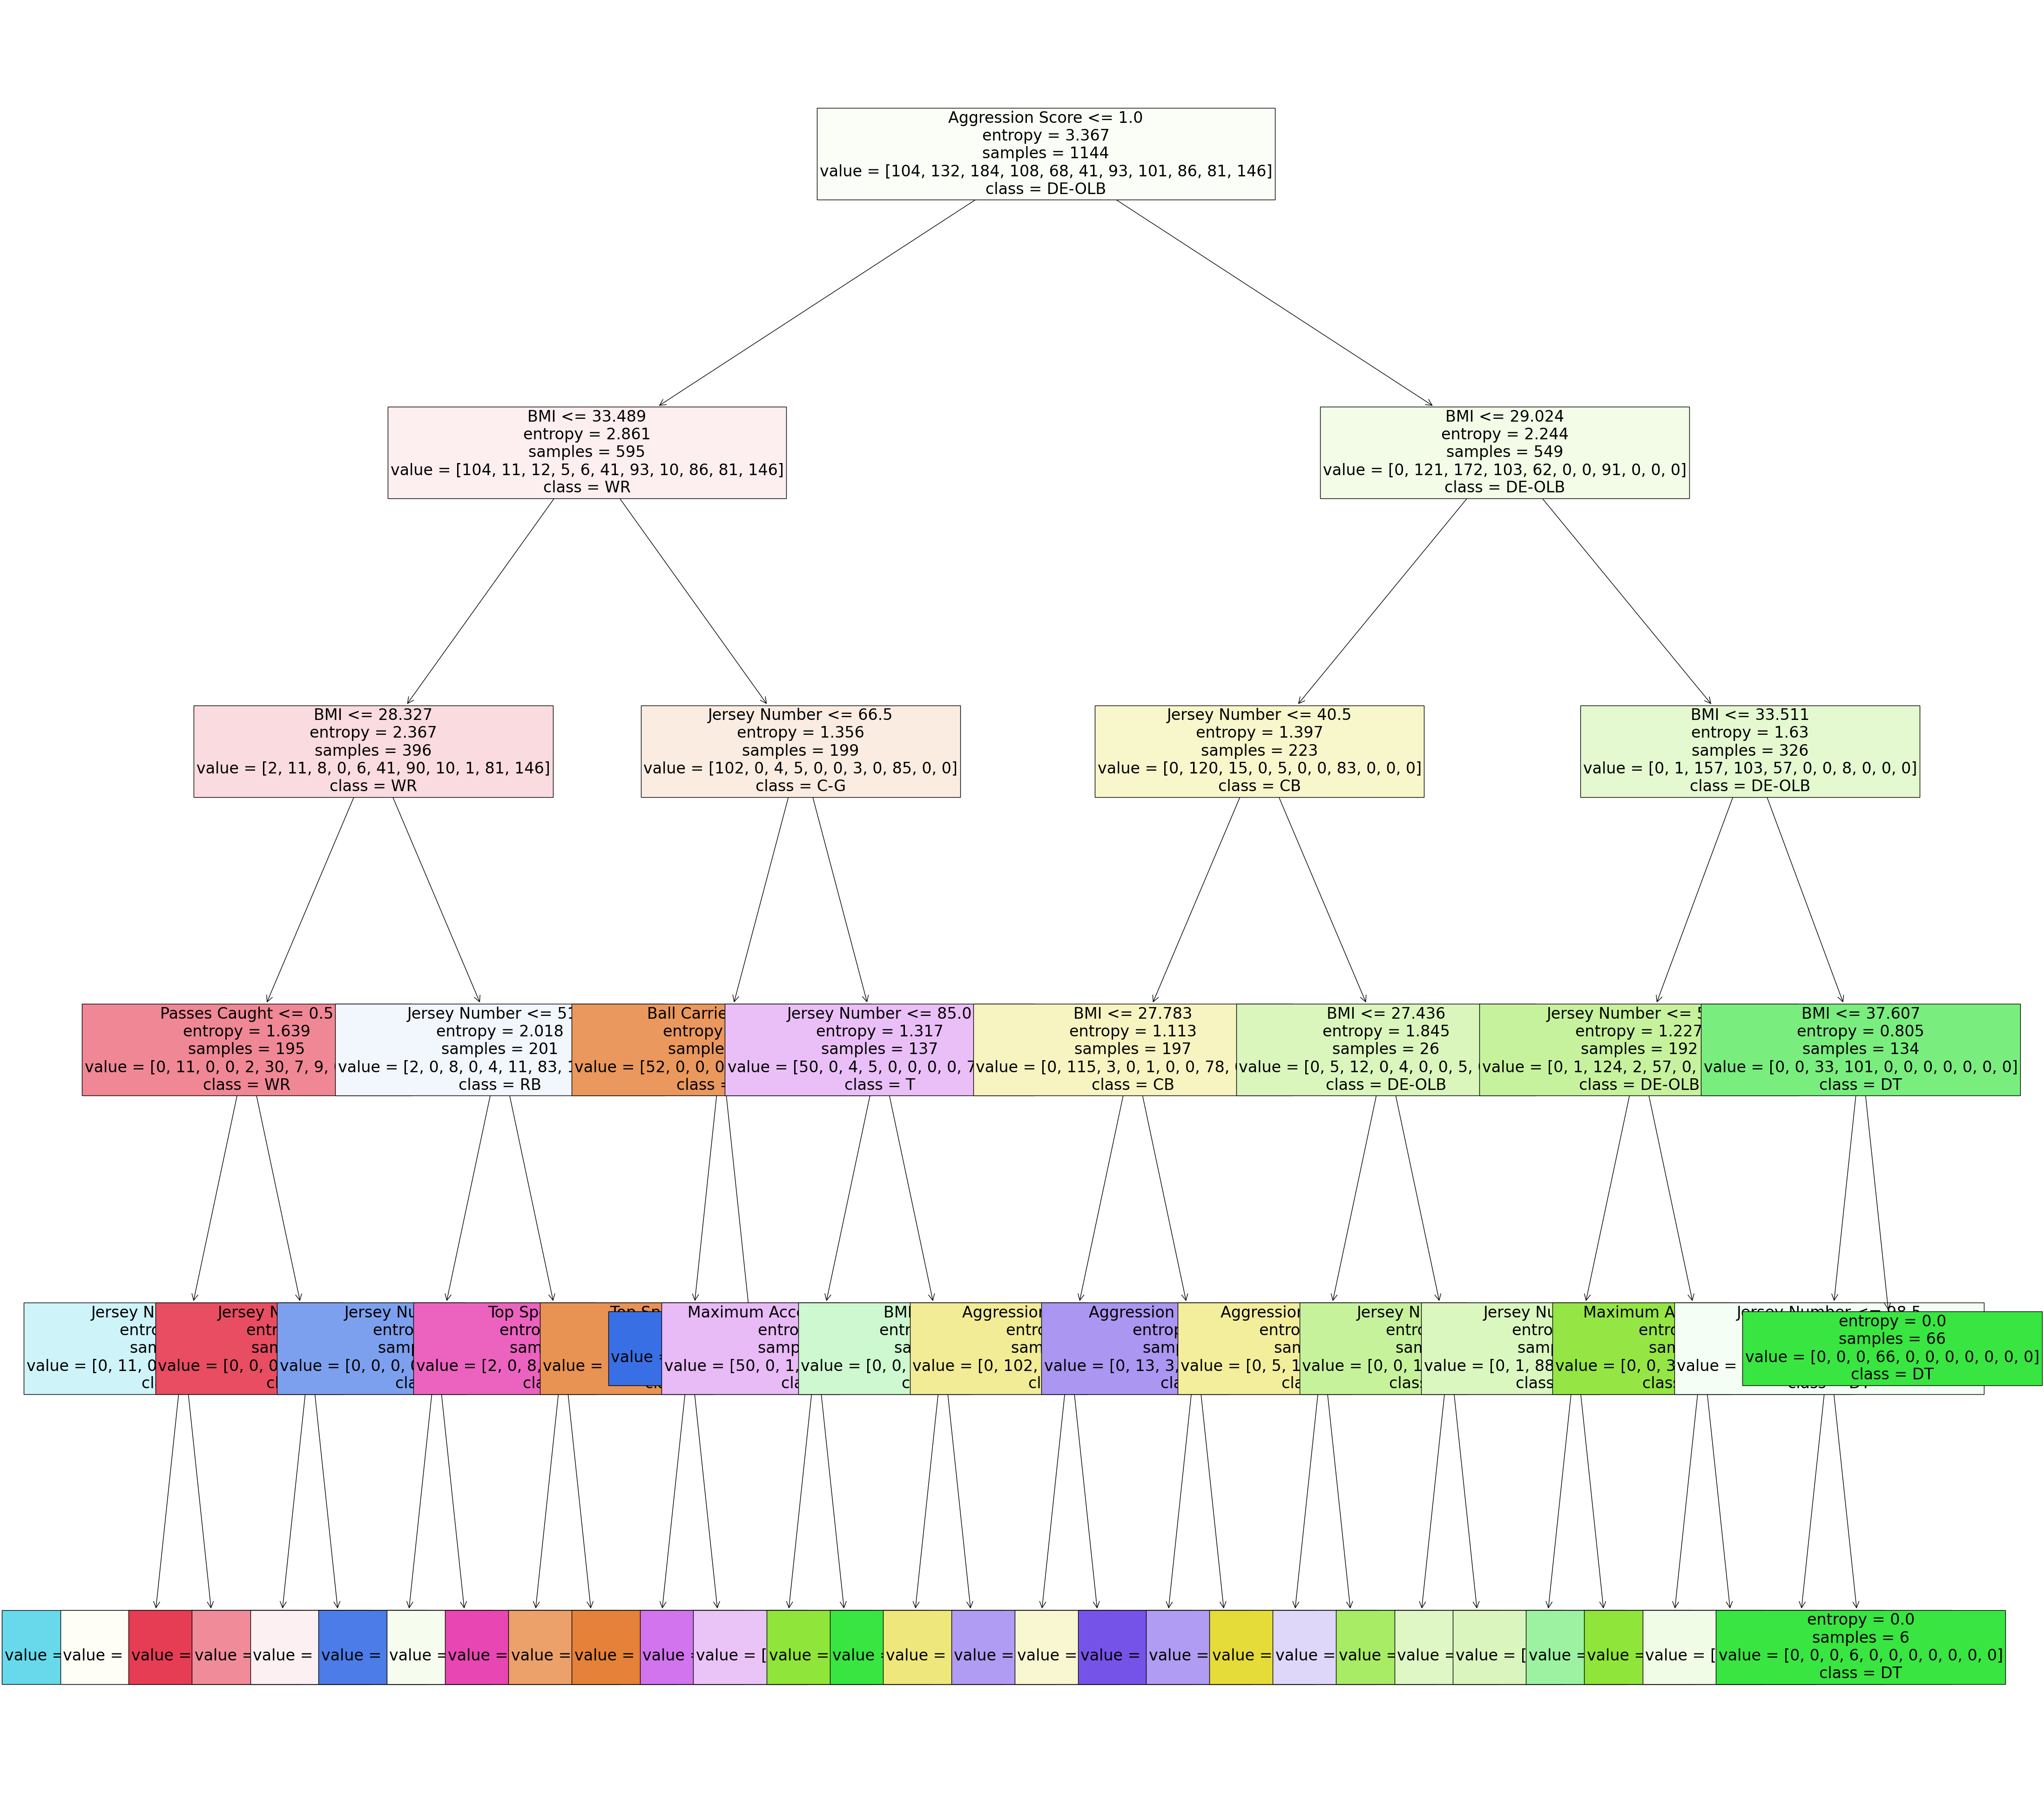

In [30]:
fig = plt.figure(figsize=[50,50])
_ = tree.plot_tree(classifier, feature_names=features.columns.tolist(), class_names=classifier.classes_.tolist(), filled=True, fontsize=24)

Confusion Matrix:


<Axes: >

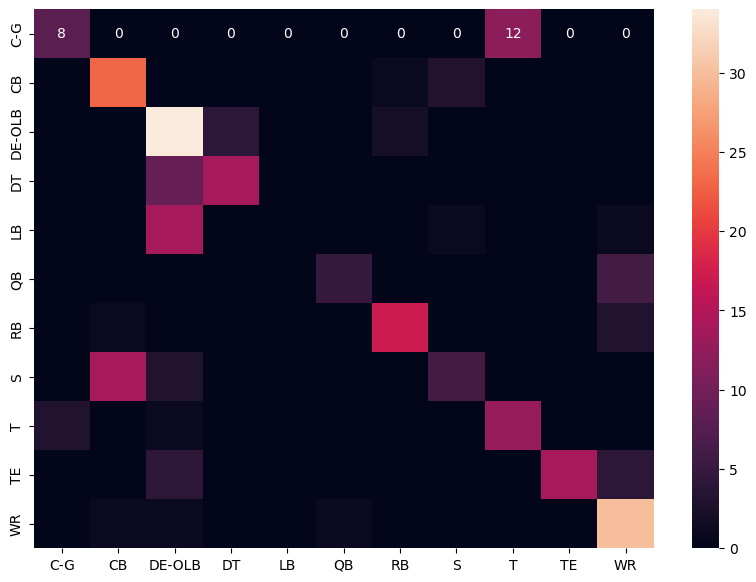

In [31]:
# Display Confusion Matrix
print("Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred, labels=classifier.classes_)

plt.figure(figsize=[10,7])
sns.heatmap(cm, annot=True, fmt='g', xticklabels=classifier.classes_, yticklabels=classifier.classes_)

array([[<Axes: title={'center': 'nflId'}>,
        <Axes: title={'center': 'Jersey Number'}>,
        <Axes: title={'center': 'BMI'}>,
        <Axes: title={'center': 'Top Speed'}>],
       [<Axes: title={'center': 'Maximum Acceleration'}>,
        <Axes: title={'center': 'Aggression Score'}>,
        <Axes: title={'center': 'Passes Caught'}>,
        <Axes: title={'center': 'Ball Carries'}>],
       [<Axes: title={'center': 'Scrambles'}>,
        <Axes: title={'center': 'Offensive Penalties'}>,
        <Axes: title={'center': 'Defensive Penalties'}>,
        <Axes: title={'center': 'Flagrant Fouls'}>],
       [<Axes: title={'center': 'Accidental Penalties'}>,
        <Axes: title={'center': 'Contact Fouls'}>, <Axes: >, <Axes: >]],
      dtype=object)

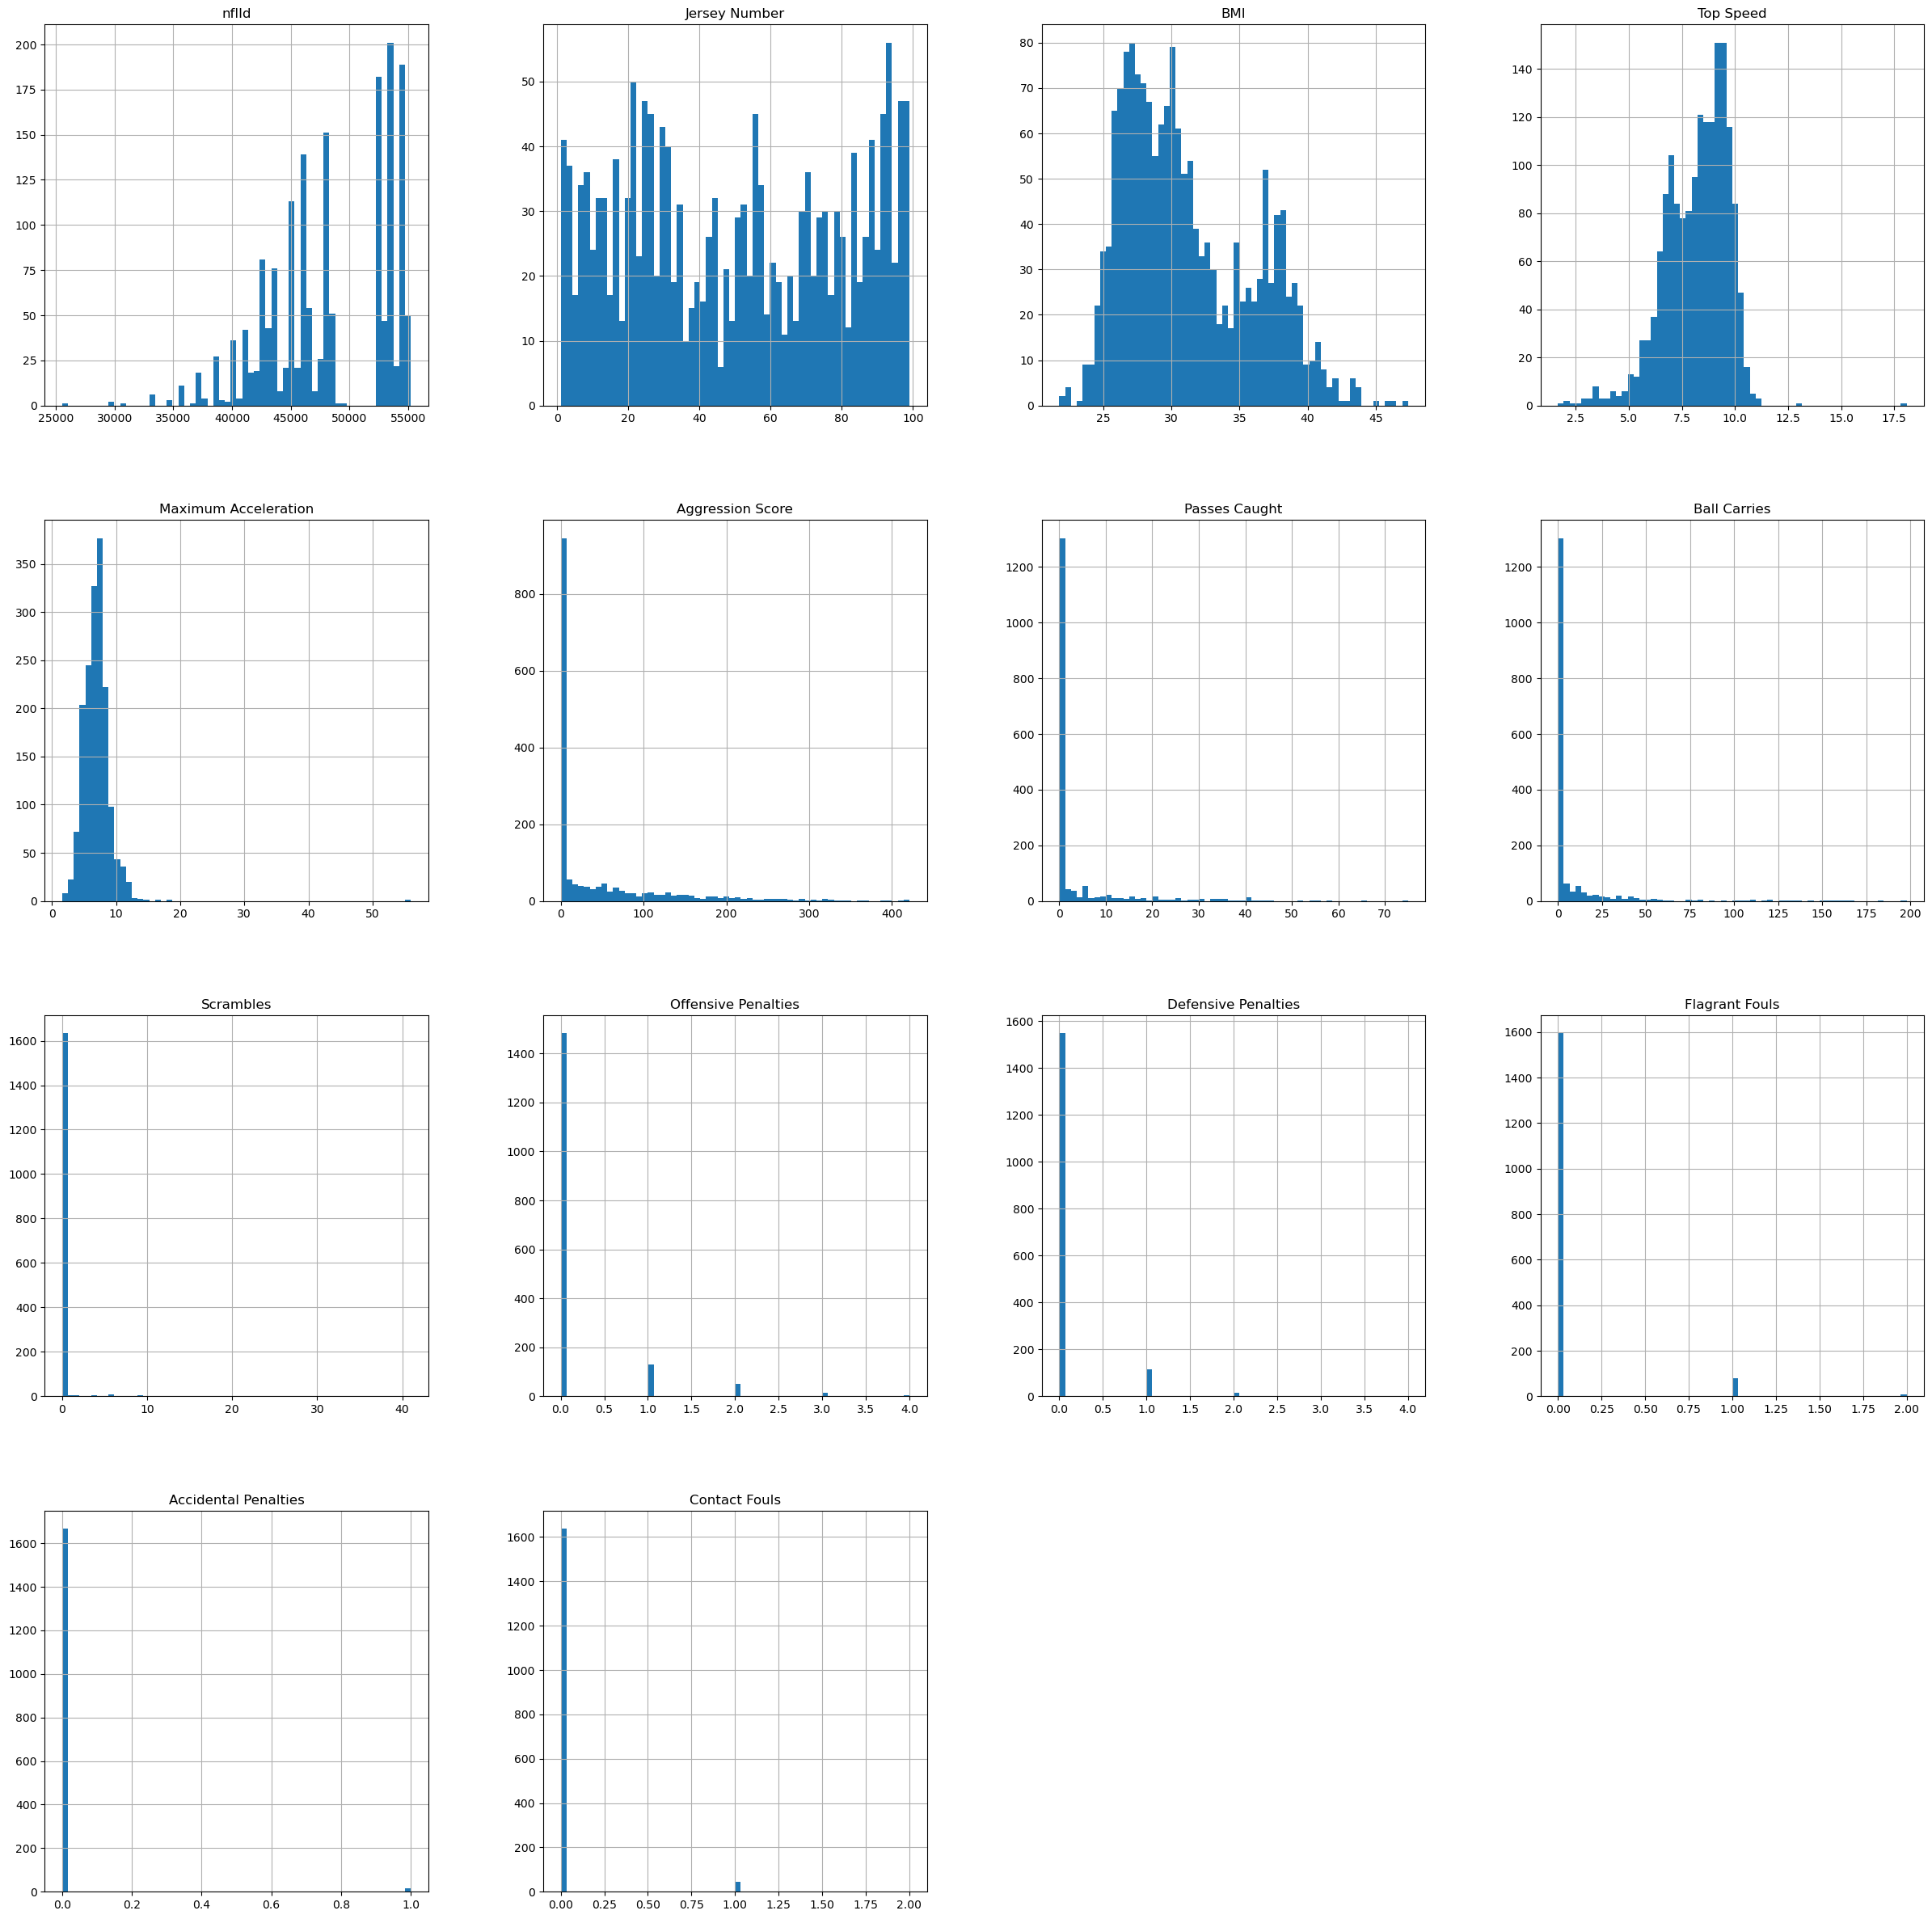

In [32]:
feature_table.hist(bins=60, figsize=[30,30])